<a href="https://colab.research.google.com/github/MinseoYoo/Animal-Sentiment-Detection/blob/main/pet_keypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms

## 전처리
Custom Dataset class를 만들고 transforms를 통해 train 데이터에 augmentation까지 적용

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = []

        # Gather all image paths and their corresponding labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_names.append(class_name)
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(class_name)

        # Split the dataset into train, valid, and test
        dataset_size = len(self.image_paths)
        indices = list(range(dataset_size))
        random.shuffle(indices)
        train_split = int(0.75 * dataset_size)
        valid_split = int(0.15 * dataset_size) + train_split
        if split == 'train':
            self.indices = indices[:train_split]
        elif split == 'valid':
            self.indices = indices[train_split:valid_split]
        elif split == 'test':
            self.indices = indices[valid_split:]
        else:
            raise ValueError("Split must be 'train', 'valid', or 'test'")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.image_paths[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        label = self.class_names.index(self.labels[self.indices[idx]])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.RandomAdjustSharpness(0),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Create dataset instances
root_dir = '/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/pet_kaggle'  # Replace with the path to your dataset

train_dataset = EmotionDataset(root_dir=root_dir, split='train', transform=train_transform)
valid_dataset = EmotionDataset(root_dir=root_dir, split='valid', transform=test_transform)
test_dataset = EmotionDataset(root_dir=root_dir, split='test', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

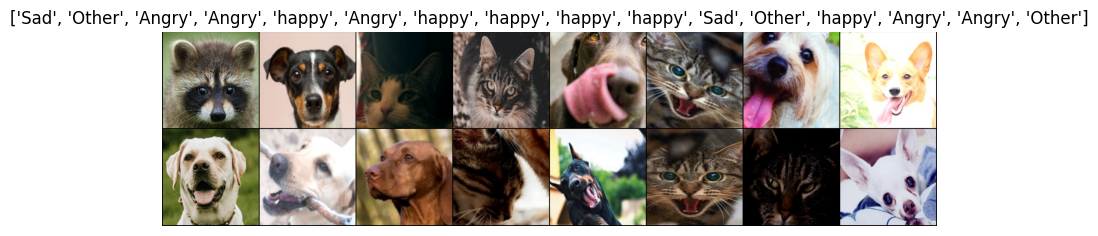

In [ ]:
import matplotlib.pyplot as plt

# Function to display images
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the batch
out = torchvision.utils.make_grid(images)

# Display images and their labels
imshow(out, title=[train_dataset.class_names[x] for x in labels])

## keypointrcnn_resnet50_fpn(pretrained=True) 이용
- 이 데이터셋에는 keypoint에 대한 정답값이 없기에 label, box, keypoints에 대해 랜덤값으로 지정하여 학습하였음. 이에 valid loss가 너무 크게 나옴
- 해결 방법: 라벨링이 되어있는 데이터를 찾아 학습 데이터로 사용한 뒤, 우리 캐글 데이터셋을 테스트로 사용
- 일단 모델 돌아가는거 확인했으니 이 부분은 freeze

In [ ]:
from PIL import Image
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Device 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델 정의
model = keypointrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# 시각화 함수 정의
def visualize_results(image, keypoints):
    draw = ImageDraw.Draw(image)
    for keypoint in keypoints:
        for x, y, v in keypoint:
            if v > 0:  # 가시성 검사를 통과한 경우만 그리기
                draw.ellipse([x-3, y-3, x+3, y+3], fill='red', outline='red')
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_and_evaluate(model, train_loader, valid_loader, num_epochs=5, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Train Loss
        for images, _ in train_loader:
            images = [image.to(device) for image in images]
            fake_boxes = [torch.tensor([[0, 0, image.shape[2], image.shape[1]]], dtype=torch.float32) for image in images]
            fake_labels = [torch.tensor([1], dtype=torch.int64) for _ in images]  # Single class
            fake_keypoints = [torch.tensor([[[0, 0, 0]]], dtype=torch.float32) for _ in images]  # Fake keypoints

            targets = [{'boxes': boxes, 'labels': labels, 'keypoints': keypoints}
                       for boxes, labels, keypoints in zip(fake_boxes, fake_labels, fake_keypoints)]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss.sum() for loss in loss_dict.values())
            else:
                raise ValueError("Model should return a dictionary of losses in train mode.")
            losses.backward()
            optimizer.step()

            train_loss += losses.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

        # Validation Loss: gradient 계산 없음, 나머지 train과 코드 동일
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for images, _ in valid_loader:
                images = [image.to(device) for image in images]
                fake_boxes = [torch.tensor([[0, 0, image.shape[2], image.shape[1]]], dtype=torch.float32) for image in images]
                fake_labels = [torch.tensor([1], dtype=torch.int64) for _ in images]  # Single class
                fake_keypoints = [torch.tensor([[[0, 0, 0]]], dtype=torch.float32) for _ in images]  # Fake keypoints

                targets = [{'boxes': boxes, 'labels': labels, 'keypoints': keypoints}
                           for boxes, labels, keypoints in zip(fake_boxes, fake_labels, fake_keypoints)]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                loss_dict = {f'loss_{i}': loss for i, loss in enumerate(loss_dict)}

                # Ensure losses are float/int values and not dicts
                losses = sum(loss.sum().item() if isinstance(loss, torch.Tensor) else sum(l.sum().item() for l in loss.values())
                for loss in loss_dict.values())
                valid_loss += losses

        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_valid_loss}")

In [ ]:
train_and_evaluate(model, train_loader, valid_loader)

In [ ]:
def evaluate_and_visualize(model, dataloader):
    model.eval()
    for images, targets in dataloader:
        images = [image.to(device) for image in images]
        with torch.no_grad():
            predictions = model(images)

        for image, prediction in zip(images, predictions):
            img = image.mul(255).byte().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = Image.fromarray(img)

            keypoints = prediction['keypoints'].cpu().numpy()
            visualize_results(img, keypoints)

# 검증 데이터셋에 대한 결과 시각화
evaluate_and_visualize(model, valid_loader)

## Facial Landmark Detection - SPIGA 사용
- sota모델은 깃이 없어서 그 다음 거 모델 사용
- 이것도 근데 라벨링이 필요해서 캐글 catFLW 사용해서 훈련
- test데이터로 우리 데이터 사용?

### catFLW load

In [ ]:
import numpy as np
import cv2
import os
import glob
import json

images = []
bboxes = []
labels = []

imgs_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/images/*.png'))

for i in range(len(imgs_list)):
    name = imgs_list[i].split('/')[-1][:-4]
    # Read the image
    image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/images/{name}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.asarray(image))

    # Read the labels and bounding boxes from JSON
    with open(f'/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/labels/{name}.json', 'r') as f:
        data = json.load(f)
        labels.append(data['labels'])
        bboxes.append(data['bounding_boxes'])

bboxes = np.array(bboxes)
labels = np.array(labels)

print(len(images), bboxes.shape, labels.shape)

2079 (2079, 4) (2079, 48, 2)


array([[[115,  85,  87],
        [115,  87,  76],
        [121,  74,  90],
        ...,
        [138, 137, 135],
        [137, 137, 135],
        [137, 137, 135]],

       [[116,  76,  64],
        [107,  95,  71],
        [115,  88,  77],
        ...,
        [138, 138, 136],
        [138, 138, 136],
        [137, 137, 135]],

       [[117,  77,  65],
        [108,  81,  60],
        [101,  68,  63],
        ...,
        [137, 137, 135],
        [136, 136, 134],
        [136, 136, 136]],

       ...,

       [[119,  90,  74],
        [130,  99,  81],
        [118,  95,  54],
        ...,
        [ 45,  19,  18],
        [ 37,  18,  14],
        [ 39,  20,  16]],

       [[ 94,  65,  49],
        [ 95,  59,  59],
        [ 92,  69,  38],
        ...,
        [ 52,  22,  22],
        [ 51,  23,  20],
        [ 53,  27,  14]],

       [[ 93,  62,  44],
        [ 70,  40,  42],
        [ 81,  47,  45],
        ...,
        [ 56,  23,  16],
        [ 56,  25,  22],
        [ 60,  27,  20]]], dtype=uint8)
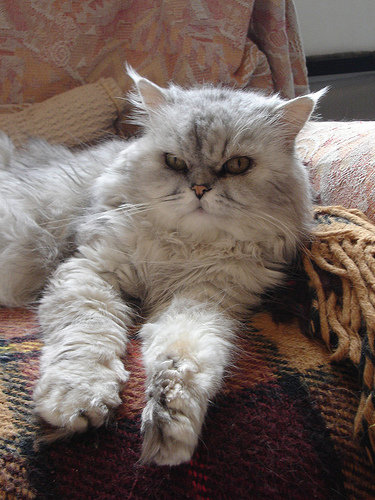

In [ ]:
images[0]

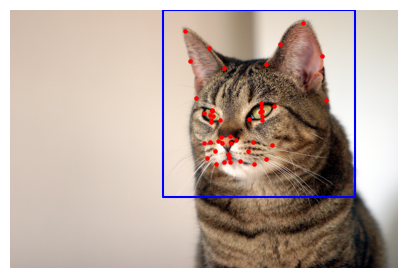

In [ ]:
import matplotlib.pyplot as plt

# Choose a random image
idx = np.random.randint(0, len(images))

# Get the image, landmarks, and bounding box
image = images[idx]
landmarks = labels[idx]
bbox = bboxes[idx]

# Create a figure and plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image)

# Plot the landmarks
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='red')

# Plot the bounding box
plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],
         [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]],
         c='blue')

plt.axis('off')
# Show the plot
plt.show()

In [ ]:
# dataloader 생성
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CatDataset(Dataset):
    def __init__(self, images, labels, bboxes, transform=None):
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        bbox = self.bboxes[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, bbox


In [ ]:
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

# Split data into training and validation sets
train_imgs, valid_imgs, train_labels, valid_labels, train_bboxes, valid_bboxes = train_test_split(
    images, labels, bboxes, test_size=0.2, random_state=42
)

# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = CatDataset(train_imgs, train_labels, train_bboxes, transform=transform)
valid_dataset = CatDataset(valid_imgs, valid_labels, valid_bboxes, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")


Training dataset size: 1663
Validation dataset size: 416


In [ ]:
def cat_training(model, train_loader, valid_loader, num_epochs=5, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Train Loss
        for images, labels, bboxes in train_loader:
            images = [image.to(device) for image in images]
            labels = [label.to(device) for label in labels]
            bboxes = [bbox.to(device) for bbox in bboxes]

            targets = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, labels)]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            if isinstance(loss_dict, dict):
                losses = sum(loss.sum() for loss in loss_dict.values())
            else:
                raise ValueError("Model should return a dictionary of losses in train mode.")

            losses.backward()
            optimizer.step()

            train_loss += losses.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

        # Validation Loss: gradient 계산 없음
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for images, labels, bboxes in valid_loader:
                images = [image.to(device) for image in images]
                labels = [label.to(device) for label in labels]
                bboxes = [bbox.to(device) for bbox in bboxes]

                targets = [{'boxes': bbox, 'labels': label} for bbox, label in zip(bboxes, labels)]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)

                if isinstance(loss_dict, dict):
                    losses = sum(loss.sum().item() for loss in loss_dict.values())
                else:
                    raise ValueError("Model should return a dictionary of losses in eval mode.")

                valid_loss += losses

        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_valid_loss}")

### spiga 불러오기
Citation: @inproceedings{Prados-Torreblanca_2022_BMVC,
  author    = {Andrés  Prados-Torreblanca and José M Buenaposada and Luis Baumela},
  title     = {Shape Preserving Facial Landmarks with Graph Attention Networks},
  booktitle = {33rd British Machine Vision Conference 2022, {BMVC} 2022, London, UK, November 21-24, 2022},
  publisher = {{BMVA} Press},
  year      = {2022},
  url       = {https://bmvc2022.mpi-inf.mpg.de/0155.pdf}
}

In [ ]:
!pip install torch torchvision opencv-python scipy

In [ ]:
!git clone https://github.com/andresprados/SPIGA.git
%cd SPIGA/
!pip install -e .

Cloning into 'SPIGA'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 337 (delta 25), reused 26 (delta 25), pack-reused 297
Receiving objects: 100% (337/337), 128.87 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Updating files: 100% (120/120), done.
/content/SPIGA
Obtaining file:///content/SPIGA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (

In [ ]:
import torch
spiga_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
cat_training(spiga_model, train_loader, valid_loader)

TypeError: ResNet.forward() takes 2 positional arguments but 3 were given

In [ ]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework

# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))
features = processor.inference(images, [bboxes])

SPIGA model loaded!


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
images[0].shape

NameError: name 'images' is not defined